# Import modules

In [1]:
import sys, os
sys.path.append('C:/Users/mpv1000/OneDrive - USNH/Documents/CUAHSI_Summer_Institute/tx-fast-hydrology')

import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import dataretrieval.nwis as nwis
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

In [2]:
# Define time period 
startdate = '20220822'
enddate = '20220825'

startdate_string = format(pd.to_datetime(startdate, format = '%Y%m%d'), '%Y-%m-%d')
enddate_string = format(pd.to_datetime(enddate, format = '%Y%m%d'), '%Y-%m-%d')

# Date range to load
date_list = pd.date_range(startdate, enddate, freq='h', tz='utc')[:-1]

# Define path for NWM forcings
forcing_path = '../data/'+startdate+'_event'
# forcing_path = 'E:/CUAHSI_SI_Theme4/Output'

# Load model collection

In [3]:
# Define model file input path
input_path = '../data/travis-county-lo-res-model-partitioned.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

In [4]:
model_collection.models

{'0': <tx_fast_hydrology.muskingum.Muskingum at 0x19720bf9a90>,
 '1': <tx_fast_hydrology.muskingum.Muskingum at 0x19721066350>,
 '2': <tx_fast_hydrology.muskingum.Muskingum at 0x197210665d0>,
 '3': <tx_fast_hydrology.muskingum.Muskingum at 0x19721066710>}

# Create model inputs

### Load NWM forcings

In [ ]:
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

# View hdf streamflow for no_data_assimilation file (24-hour window) 
# pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')

# View hds streamflow for short_range forecast file (18-hours) 
# pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__streamflow')

In [6]:
# print(streamflow.index)
# print(pd.to_datetime(streamflow.index, '%Y-%m-%d %H:%M:%S+00:00'))
temp = []
for i in streamflow.index: 
    # print(i)
    temp.append(pd.to_datetime(i, '%Y-%m-%d %H:%M:%S+00:00').date())

print(pd.DataFrame(temp, columns = ['dt'])['dt'].unique())

[datetime.date(2022, 8, 22) datetime.date(2022, 8, 23)
 datetime.date(2022, 8, 24)]


### Create inputs to model based on forcings

In [7]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

# Fill input table with forcings for each reach
for col in inputs.columns:
    if col in forcing.columns:
        inputs[col] = forcing[col]

# Add inflow to upstream boundary reaches
upstream_inputs = {
    '5779305' : '5781161',
    '5785187' : '5785899',
    '5786029' : '5785351'
}
for downstream_reach, upstream_reach in upstream_inputs.items():
    inputs[downstream_reach] += streamflow[upstream_reach]

In [ ]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

# inputs.head(n=5)

# Gather gage measurements for event period

In [16]:
# Download data from USGS dataretrieval
usgs_comid_df = pd.read_csv('../data/usgs_to_comid.csv', index_col=0)
usgs_comid_df['gage_id'] = usgs_comid_df['gage_id'].astype(str)
usgs_comid_df['comid'] = usgs_comid_df['comid'].astype(str)
# Filter 
usgs_comid_df = usgs_comid_df[usgs_comid_df['comid'].isin(input_columns)]

# Prepare gage IDs for USGS dataretrieval 
sites = usgs_comid_df.gage_id.dropna().astype(int).astype(str).reset_index(drop = True)
# sites = usgs_to_comid.usgs_id.dropna().astype(int).astype(str).reset_index(drop = True)
site_ids = []
for i in sites: 
    site_ids.append(i.zfill(8)) # add leading zeros to gage IDs 
# print(site_ids)
print('Number of gages: ' + str(len(site_ids)))

# Get site info 
TCsites = nwis.what_sites(sites = site_ids, startDT=startdate_string, endDT=enddate_string, parameterCd="00060")
TCsites[0].head()

Number of gages: 38


,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,geometry
0,USGS,08105872,"Brushy Ck at Cedar Park, TX",ST,30.525181,-97.749992,5,NAD83,765.16,0.10,NAVD88,12070205,POINT (-97.74999 30.52518)
1,USGS,08105883,"Brushy Ck at IH 35, Round Rock, TX",ST,30.512906,-97.686436,H,NAD83,689.85,0.10,NAVD88,12070205,POINT (-97.68644 30.51291)
2,USGS,08105886,"Lake Ck at Lake Ck Pkwy nr Austin, TX",ST,30.465556,-97.787889,S,NAD83,897.58,0.13,NAVD88,12070205,POINT (-97.78789 30.46556)
3,USGS,08105888,"Brushy Ck at Kenney Fort Blvd at Round Rock, TX",ST,30.512394,-97.636672,1,NAD83,638.36,0.10,NAVD88,12070205,POINT (-97.63667 30.51239)
4,USGS,08154700,"Bull Ck at Loop 360 nr Austin, TX",ST,30.372148,-97.784730,F,NAD83,535.05,0.22,NAVD88,12090205,POINT (-97.78473 30.37215)


20220822
20220825
08105883
08158970
08172400
08158045
08158930
08155200
08159000
08158380
08156910
08105888
08155400
08105886
08105872
08158927
08157540
08154700
08158840
08159110
08155300
08158000
08158035
08158600
08159250
08155240
08156800
08158827
08158860
08155541
08158813
08158030
08156675
08158700
08158920
08155500
08158200
08158810
08159105
08158922
08158922
Empty DataFrame
Columns: [site_no]
Index: []


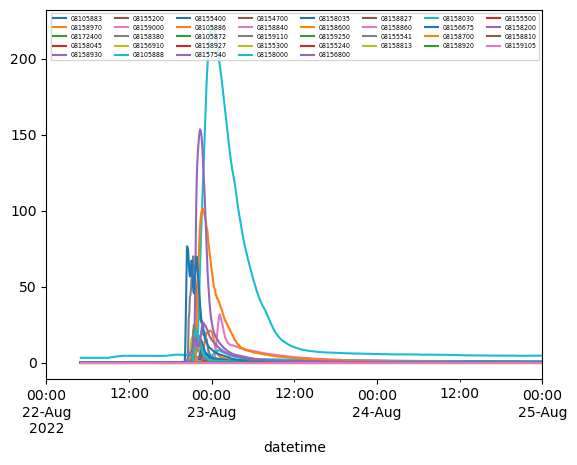

In [ ]:
# Restructure data for h5 file 
eventdata = [] 
print(startdate)
print(enddate)

for i in list(set(site_ids)): 
    print(i)
    # fig, ax = plt.subplots()
    df = nwis.get_iv(sites=i, start=startdate_string, end=enddate_string, parameterCd='00060')
    df = pd.DataFrame(df[0])
    if len(df.columns) == 3 and len(df) > 0: 
        df.columns = ['site_no', '00060', 'sensor_cd']
        # print(df.columns)
        # ax.plot(df.index, df['00060']) #df['00060_primary sensor'])
        df1 = pd.DataFrame(df['00060'])
        df1.columns = [i]
        eventdata.append(df1)
    else: 
        # ax.plot(df.index, df.iloc[:,1])
        print(i)
        print(df)
        # df1 = pd.DataFrame(df.iloc[:,1])
    # plt.suptitle(i)
    # plt.show()

df2 = (pd.concat(eventdata, axis = 1))
# print(df2)

# Convert cfs to cms 
df3 = df2*0.02831683199881

df3.plot()
# plt.legend(ncol = 8, loc = 'upper right', prop = {'size' : 4.5})
plt.xlim(startdate, enddate)

df3.loc[:, ~df3.columns.duplicated()].to_hdf('../../Project_Data/gages_usgs_'+startdate+'_to_'+enddate+'.h5', key = 'usgs', mode = 'w')

In [18]:
# Load table of mappings from USGS Gage IDs to NWM COMIDs
usgs_to_comid = pd.read_csv('../data/usgs_to_comid.csv', index_col=0)
usgs_to_comid['gage_id'] = usgs_to_comid['gage_id'].astype(str)
usgs_to_comid['comid'] = usgs_to_comid['comid'].astype(str)
# Filter 
usgs_to_comid = usgs_to_comid[usgs_to_comid['comid'].isin(input_columns)]
usgs_to_comid = pd.Series(usgs_to_comid['comid'].values, index=usgs_to_comid['gage_id'].values)
# Drop missing gages 
usgs_to_comid = usgs_to_comid.drop(['8158922'])

# Load table of USGS gage measurements
# measurements = pd.read_hdf('../data/gages.h5', key='usgs')
measurements = pd.read_hdf('../../Project_Data/gages_usgs_' + startdate + '_to_' + enddate + '.h5', key = 'usgs')
measurements.columns = measurements.columns.astype(int).astype(str)
# Filter measurements to those with associated COMIDs
measurements = measurements[usgs_to_comid.index]
measurements.columns = measurements.columns.map(usgs_to_comid)
measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]
measurements = measurements.dropna(axis=1)
measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()

# Set up Kalman Filter

In [19]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        Q_cov = 1. * np.eye(model.n)
        # Measurement noise covariance matrix
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        model.bind_callback(kf, key='kf')

# Prepare and simulate model

### Prepare model for simulation

In [20]:
# Add downstream boundaries to model
for model in model_collection.models.values():
    outlet = model.startnodes[model.startnodes == model.endnodes].item()
    model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

### Simulate model

In [21]:
# Simulate models
outputs_da = await simulation.simulate()
# Collect outputs into a single table
outputs_da = pd.concat([series for series in outputs_da.values()], axis=1)

# Plot results

Text(0.5, 1.0, 'Travis County Model: Discharge response to storm event on 2022-08-22')

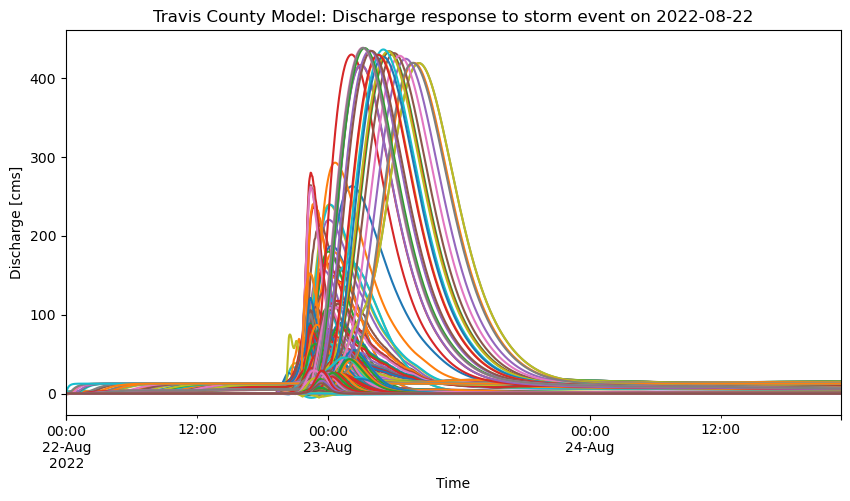

In [22]:
# New streamflow data 
fig, ax = plt.subplots(figsize=(10, 5))

outputs_da.plot(ax=ax, legend=False)
plt.xlabel('Time')
plt.ylabel('Discharge [cms]')
plt.title('Travis County Model: Discharge response to storm event on ' + startdate_string)
# plt.legend()

# Compare results

### Run model without DA

In [23]:
# Define model file input path
input_path = '../data/travis-county-lo-res-model-partitioned.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

# Add downstream boundaries to model
for model in model_collection.models.values():
    outlet = model.startnodes[model.startnodes == model.endnodes].item()
    model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

# Simulate models
outputs_noda = await simulation.simulate()
# Collect outputs into a single table
outputs_noda = pd.concat([series for series in outputs_noda.values()], axis=1)

In [25]:
# View data 
outputs_noda.head()
outputs_noda.max()

# outputs_da.head()
# outputs_da.max()

5671171    31.853640
5671165    31.853640
5671187    30.152371
5671185    31.291924
5671181    24.422384
             ...    
1629525    18.505141
1629809    18.471224
1629805    29.218839
1629803    16.296559
1629801    12.948016
Length: 916, dtype: float64

In [26]:
# Organize and export model ouptu data 
outputs = pd.concat([pd.DataFrame(outputs_da.max(), columns = ['q_cms_da']), pd.DataFrame(outputs_noda.max(), columns = ['q_cms_no_da'])], axis = 1)
outputs.index = outputs.index.astype(int)
# print(outputs.index)
# outputs.to_csv('../../Project_Data/model_collection_with_da_2022-08-22.csv')

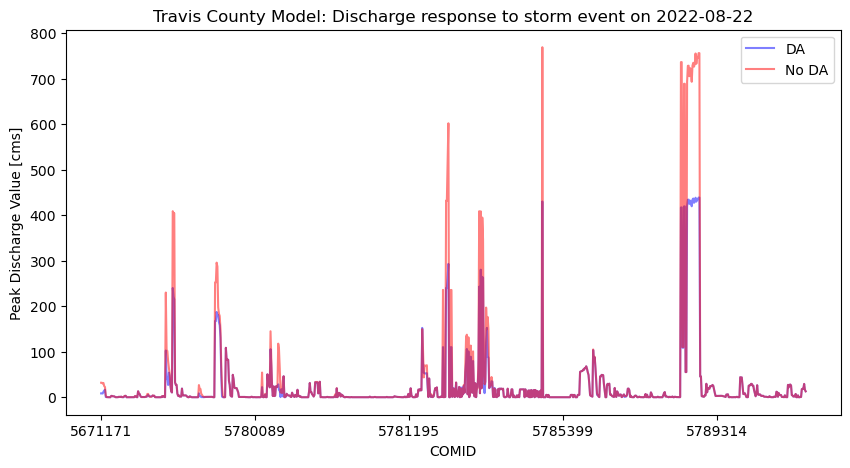

In [27]:
# New streamflow data 
fig, ax = plt.subplots(figsize=(10, 5))

outputs_da.max().plot(ax=ax, color = 'b', alpha = 0.5, label = 'DA', legend=False)
outputs_noda.max().plot(ax=ax, color = 'r', alpha = 0.5, label = 'No DA', legend=False)
plt.xlabel('COMID')
plt.ylabel('Peak Discharge Value [cms]')
plt.title('Travis County Model: Discharge response to storm event on ' + startdate_string)
plt.legend()

### Plot model result vs. KF vs. measurements at gage locations

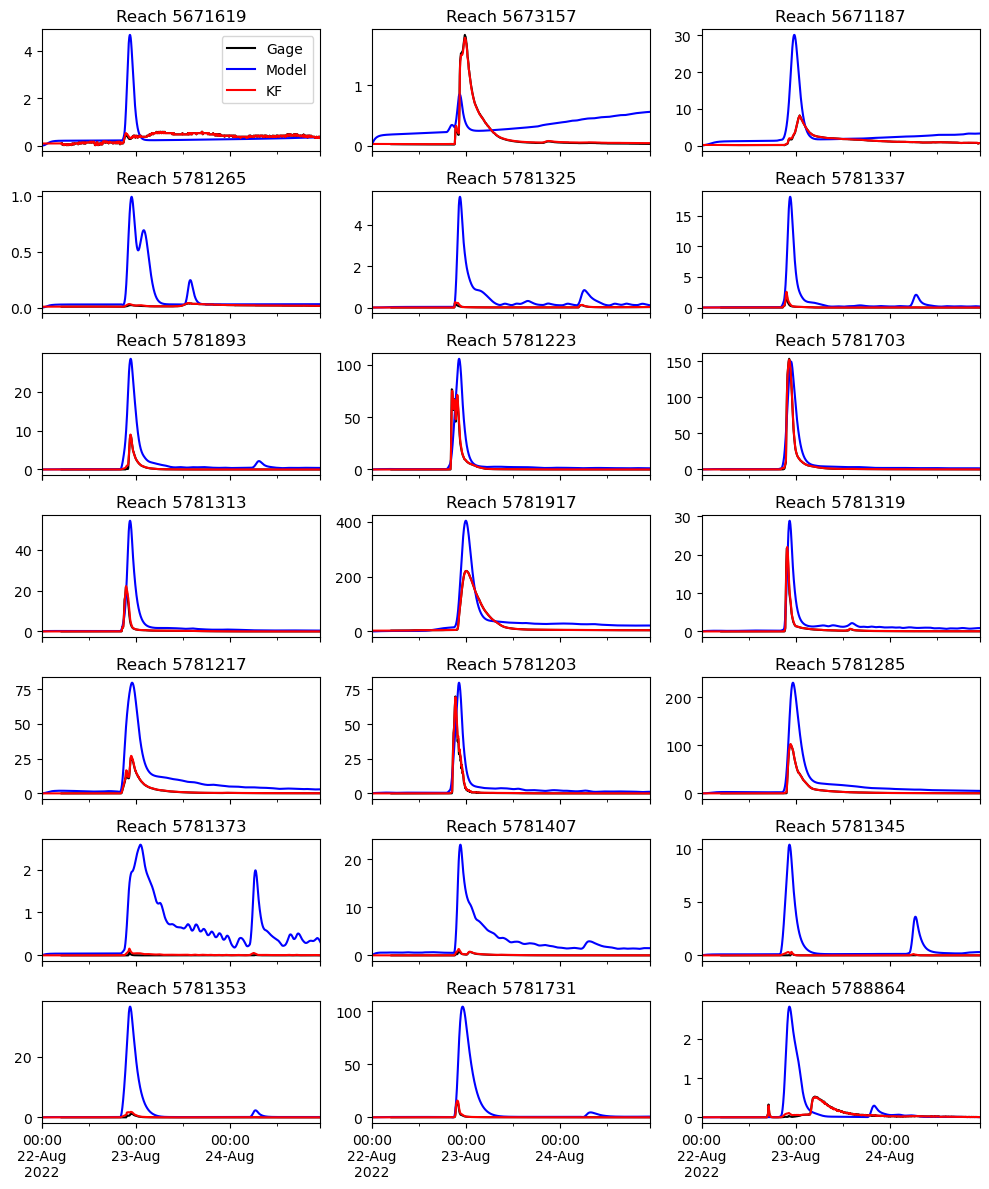

In [28]:
# New data 
fig, ax = plt.subplots(measurements.columns.size // 3, 3, figsize=(10, 12))

for index, comid in enumerate(measurements.columns):
    measurements[comid].plot(ax=ax.flat[index], c='k', label='Gage')
    outputs_noda[comid].plot(ax=ax.flat[index], c='b', label='Model')
    outputs_da[comid].plot(ax=ax.flat[index], c='r', label='KF')
    if index < measurements.columns.size - 3:
        ax.flat[index].xaxis.set_ticklabels([])
    ax.flat[index].xaxis.set_ticklabels([], minor=True)
    ax.flat[index].set_title(f'Reach {comid}')
    ax.flat[index].set_xlabel('')
ax.flat[0].legend()
plt.tight_layout()

### Plot map of gains

In [29]:
total_gain = (outputs_da - outputs_noda).mean(axis=0)

In [30]:
nwm_streams_tx = gpd.read_file('../data/nwm_streams_tx')
nwm_streams_tx['ID'] = nwm_streams_tx['ID'].astype(int).astype(str)
nwm_streams_travis = nwm_streams_tx[nwm_streams_tx['ID'].isin(input_columns)].copy()
nwm_streams_travis['gain'] = nwm_streams_travis['ID'].map(total_gain).fillna(0.).values
nwm_streams_travis['log_gain'] = np.log(1 + np.abs(nwm_streams_travis['gain'].values))

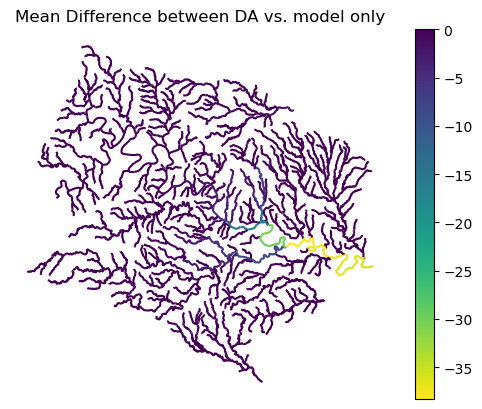

In [31]:
nwm_streams_travis.plot(column='gain', cmap='viridis_r', legend=True)
plt.title('Mean Difference between DA vs. model only')
_ = plt.axis('off')

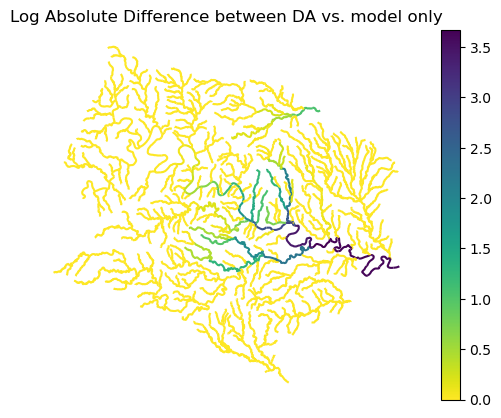

In [32]:
nwm_streams_travis.plot(column='log_gain', cmap='viridis_r', legend=True)
plt.title('Log Absolute Difference between DA vs. model only')
_ = plt.axis('off')